In [1]:
!pip install -qq pyspark matplotlib seaborn pandas

import os

# Set matplotlib cache directory to avoid write permission warnings
mpl_cache_dir = os.path.join(os.getcwd(), ".mpl_cache")
os.makedirs(mpl_cache_dir, exist_ok=True)
os.environ['MPLCONFIGDIR'] = mpl_cache_dir

import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set the target directory to '../data' relative to the notebook
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

# Base URL for the 10BT Sample
base_url = "https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu/resolve/main/sample/10BT"

# Loop through files 000 to 013
for i in range(14):
    filename = f"{i:03d}_00000.parquet"
    save_path = os.path.join(data_dir, filename)
    
    # Only download if missing
    if not os.path.exists(save_path):
        print(f"Downloading {filename}...")
        !wget -q -O {save_path} {base_url}/{filename}
    else:
        print(f"Skipping {filename} (Already exists)")

print("All 14 sample files downloaded.")

Skipping 000_00000.parquet (Already exists)
Skipping 001_00000.parquet (Already exists)
Skipping 002_00000.parquet (Already exists)
Skipping 003_00000.parquet (Already exists)
Skipping 004_00000.parquet (Already exists)
Skipping 005_00000.parquet (Already exists)
Skipping 006_00000.parquet (Already exists)
Skipping 007_00000.parquet (Already exists)
Skipping 008_00000.parquet (Already exists)
Skipping 009_00000.parquet (Already exists)
Skipping 010_00000.parquet (Already exists)
Skipping 011_00000.parquet (Already exists)
Skipping 012_00000.parquet (Already exists)
Skipping 013_00000.parquet (Already exists)
All 14 sample files downloaded.


In [3]:
# Create SparkSession with specified configurations
spark = SparkSession.builder \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "15g") \
    .config("spark.executor.instances", 7) \
    .getOrCreate()

spark

In [4]:
# Read all parquet files from the '../data' directory into a single DataFrame
df = spark.read.parquet("../data")

In [5]:
# Show the schema of the DataFrame to verify it loaded correctly
df.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: string (nullable = true)
 |-- dump: string (nullable = true)
 |-- url: string (nullable = true)
 |-- file_path: string (nullable = true)
 |-- language: string (nullable = true)
 |-- language_score: double (nullable = true)
 |-- token_count: long (nullable = true)
 |-- score: double (nullable = true)
 |-- int_score: long (nullable = true)



In [6]:
%%time
# Total number of rows
print(f"Total rows: {df.count():,}")

Total rows: 9,672,101
CPU times: user 499 µs, sys: 614 µs, total: 1.11 ms
Wall time: 2.71 s


In [7]:
%%time
# How many partitions Spark created (affects parallelism)
print(f"Number of partitions: {df.rdd.getNumPartitions()}")

Number of partitions: 213
CPU times: user 264 µs, sys: 1.28 ms, total: 1.54 ms
Wall time: 71.9 ms


In [8]:
# Show what rows look like and substring(text, 1, 200) shows only the first 200 chars to keep output readable.

from pyspark.sql import functions as F

df.select(
    "id",
    "language",
    "language_score",
    "token_count",
    "score",
    "int_score",
    F.substring("text", 1, 200).alias("text_preview")
).show(5, truncate=False)


+-----------------------------------------------+--------+------------------+-----------+-------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                                             |language|language_score    |token_count|score  |int_score|text_preview                                                                                                                                                                                             |
+-----------------------------------------------+--------+------------------+-----------+-------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|<urn:uuid:b586aede-fa40-432a-9d38-f07d0fc8ed89>|en      |0.9757229089

In [9]:
# Compute summary statistics for each field
df.describe().show()

+-------+--------------------+--------------------+---------------+--------------------+--------------------+--------+------------------+------------------+------------------+-------------------+
|summary|                text|                  id|           dump|                 url|           file_path|language|    language_score|       token_count|             score|          int_score|
+-------+--------------------+--------------------+---------------+--------------------+--------------------+--------+------------------+------------------+------------------+-------------------+
|  count|             9672101|             9672101|        9672101|             9672101|             9672101| 9672101|           9672101|           9672101|           9672101|            9672101|
|   mean|                NULL|                NULL|           NULL|                NULL|                NULL|    NULL|0.9362028150343236|1031.1015338859675| 3.006352990485211|  3.133958278558092|
| stddev|           

In [10]:
# Observe how document length varies by each score bucket
quality_bucket = (
    df.groupBy("int_score")
      .agg(
          F.count("*").alias("n_docs"),
          F.avg("token_count").alias("avg_tokens")
      )
      .orderBy("int_score")
)
quality_bucket.show()

+---------+-------+------------------+
|int_score| n_docs|        avg_tokens|
+---------+-------+------------------+
|        3|8383873|1022.5527939175605|
|        4|1280798|1087.8567346295044|
|        5|   7430| 893.7667563930014|
+---------+-------+------------------+



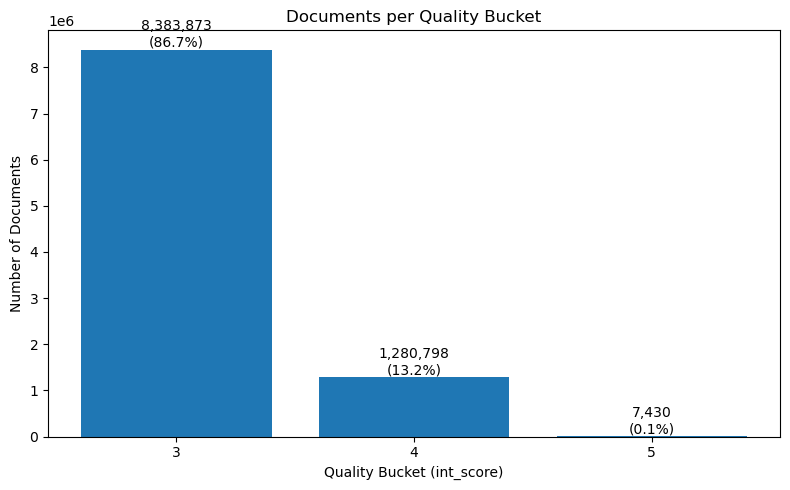

In [11]:
pdf = quality_bucket.toPandas()

plt.figure(figsize=(8,5))
bars = plt.bar(pdf["int_score"], pdf["n_docs"])

plt.xlabel("Quality Bucket (int_score)")
plt.ylabel("Number of Documents")
plt.title("Documents per Quality Bucket")

plt.xticks(pdf["int_score"])

# Add labels
total = pdf["n_docs"].sum()
for i, v in enumerate(pdf["n_docs"]):
    pct = v / total * 100
    plt.text(pdf["int_score"][i],
             v,
             f"{v:,}\n({pct:.1f}%)",
             ha='center',
             va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# How many unique web domains? Which are the most frequently occurring?
from pyspark.sql.functions import regexp_extract

df_domains = df.withColumn(
    "domain",
    regexp_extract("url", r"https?://([^/]+)", 1)
)
distinct_url = df_domains.select("domain").distinct().count()
print("Unique Domains:", distinct_url)

top_domains = df_domains.groupBy("domain") \
    .count() \
    .orderBy("count", ascending=False)

top_domains.show(20, truncate=False)

Unique Domains: 2088546
+---------------------------+-----+
|domain                     |count|
+---------------------------+-----+
|en.wikipedia.org           |64429|
|www.britannica.com         |22569|
|www.reference.com          |22180|
|www.enotes.com             |19872|
|phys.org                   |15223|
|www.teacherspayteachers.com|14453|
|www.sciencedaily.com       |13442|
|www.eurekalert.org         |12887|
|www.bookrags.com           |11953|
|www.newscientist.com       |11264|
|slideplayer.com            |11264|
|en.wikisource.org          |10638|
|www.redorbit.com           |10565|
|www.oxforddictionaries.com |10179|
|www.gardenguides.com       |9573 |
|simple.wikipedia.org       |9521 |
|www.theguardian.com        |9232 |
|www.studymode.com          |8641 |
|everything2.com            |8247 |
|www.livestrong.com         |8072 |
+---------------------------+-----+
only showing top 20 rows



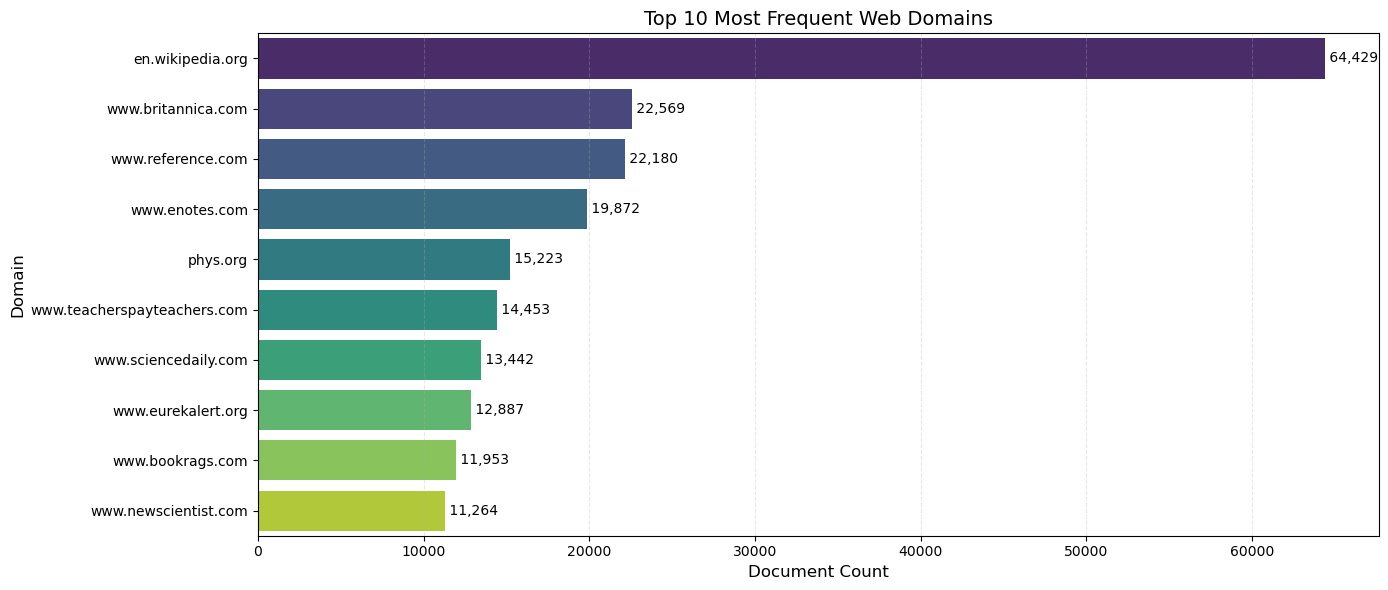

In [13]:
# Convert to pandas
top_domains_pdf = top_domains.limit(10).toPandas()

plt.figure(figsize=(14, 6))
sns.barplot(data=top_domains_pdf, x="count", y="domain", palette='viridis', hue="domain", legend=False)
plt.title("Top 10 Most Frequent Web Domains", fontsize=14)
plt.xlabel("Document Count", fontsize=12)
plt.ylabel("Domain", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
# Add counts to bars
for index, row in top_domains_pdf.iterrows():
    plt.text(row['count'], index, f" {row['count']:,}", va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [14]:
# Count nulls per column to check missingness
null_counts = df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])
null_counts.show(truncate=False)

# Specifically check empty text rows (null or length 0)
df.select(
    F.sum((F.col("text").isNull() | (F.length("text") == 0)).cast("int")).alias("empty_text_rows")
).show()


+----+---+----+---+---------+--------+--------------+-----------+-----+---------+
|text|id |dump|url|file_path|language|language_score|token_count|score|int_score|
+----+---+----+---+---------+--------+--------------+-----------+-----+---------+
|0   |0  |0   |0  |0        |0       |0             |0          |0    |0        |
+----+---+----+---+---------+--------+--------------+-----------+-----+---------+

+---------------+
|empty_text_rows|
+---------------+
|              0|
+---------------+



In [15]:
# token_count summary: shows scale and skew (min/median/mean/max)
df.select(
    F.min("token_count").alias("min_tokens"),
    F.expr("percentile_approx(token_count, 0.5)").alias("median_tokens"),
    F.mean("token_count").alias("mean_tokens"),
    F.max("token_count").alias("max_tokens")
).show()

# score summary: range and central tendency
df.select(
    F.min("score").alias("min_score"),
    F.expr("percentile_approx(score, 0.5)").alias("median_score"),
    F.mean("score").alias("mean_score"),
    F.max("score").alias("max_score")
).show()


+----------+-------------+------------------+----------+
|min_tokens|median_tokens|       mean_tokens|max_tokens|
+----------+-------------+------------------+----------+
|        42|          629|1031.1015338859675|    170927|
+----------+-------------+------------------+----------+

+---------+------------+-----------------+---------+
|min_score|median_score|       mean_score|max_score|
+---------+------------+-----------------+---------+
| 2.515625|     2.90625|3.006352990485211|  5.34375|
+---------+------------+-----------------+---------+



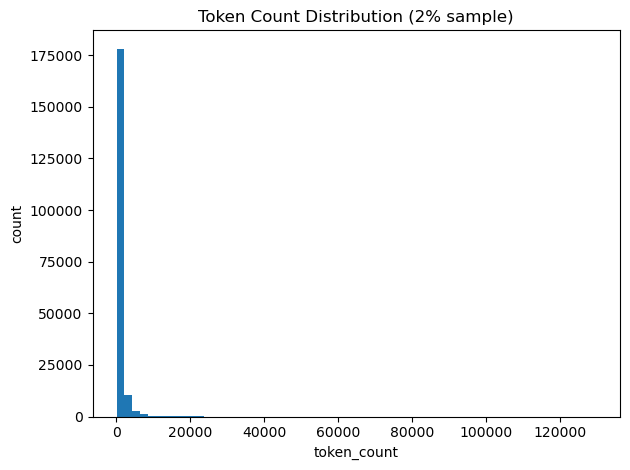

In [16]:
# Convert a small random sample to pandas for plotting with matplotlib.
import matplotlib.pyplot as plt


sample_tokens = (df.select("token_count")
                   .where(F.col("token_count").isNotNull())
                   .sample(False, 0.02, seed=42)   # 2% sample
                   .toPandas())

plt.figure()
plt.hist(sample_tokens["token_count"], bins=60)
plt.title("Token Count Distribution (2% sample)")
plt.xlabel("token_count")
plt.ylabel("count")
plt.tight_layout()
plt.show()


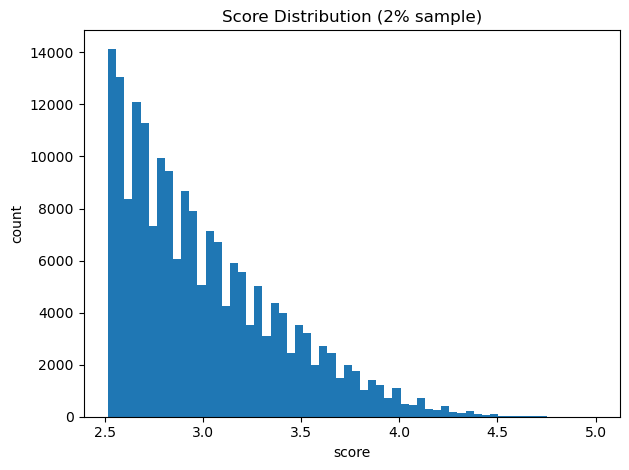

In [17]:
# Plot distribution of educational quality score
sample_scores = (df.select("score")
                   .where(F.col("score").isNotNull())
                   .sample(False, 0.02, seed=42)   # 2% sample
                   .toPandas())

plt.figure()
plt.hist(sample_scores["score"], bins=60)
plt.title("Score Distribution (2% sample)")
plt.xlabel("score")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [18]:
# Preprocessing idea:
# - remove null text
# - remove extremely short documents
# - enforce minimum token_count
# - dedupe by id
clean_df = (df
    .filter(F.col("text").isNotNull())
    .filter(F.length("text") > 200)
    .filter(F.col("token_count") >= 50)
    .dropDuplicates(["id"])
)

print("Rows before cleaning:", df.count())
print("Rows after cleaning:", clean_df.count())


Rows before cleaning: 9672101
Rows after cleaning: 9672072
